In [1]:
import pandas as pd
import numpy as np

import random

import plotly.offline as py
import plotly.graph_objects as go

import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

from tqdm import tqdm

import pickle

In [428]:
orders = pd.read_csv('instacart_data/order_products__train.csv', usecols = ['order_id', 'product_id'])
orders_prior = pd.read_csv('instacart_data/order_products__prior.csv')
products = pd.read_csv('instacart_data/products.csv')

In [438]:
# Get a wide range of orders
order_ids = orders.order_id.unique()
order_ids = random.sample(set(order_ids), int(len(order_ids)*0.01))

In [439]:
len(order_ids)

32148

In [440]:
products.head()
orders_small = orders[orders['order_id'].isin(order_ids)]
orders_small = orders_small.merge(products.loc[:, ['product_id', 'product_name']], how = 'left')

In [2]:
# with open('reduced_orders.pickle', 'wb') as f:
#     pickle.dump(orders_small, f)
with open('reduced_orders.pickle', 'rb') as f:
    orders_small  = pickle.load(f)

In [3]:
# orders_small.head()
# To simplify what the orders look like, I've replaced 'bag of organic bananas' with just 'bananas'
orders_small['product_name'] = orders_small['product_name'].replace({'Bag of Organic Bananas': 'Banana'})

In [4]:
orders_small.head()

,order_id,product_id,add_to_cart_order,reordered,product_name
0,11,30162,1,1,Teriyaki & Pineapple Chicken Meatballs
1,11,27085,2,1,Mango Pineapple Salsa
2,11,5994,3,1,Traditional Refried Beans
3,11,1313,4,1,Tortilla Strips Restaurant Style
4,11,31506,5,1,Extra Virgin Olive Oil


In [453]:
paired_products = []

# Create the pairwise product combinations
for order_id in tqdm(order_ids):
    tmp_df = orders_small[orders_small['order_id'] == order_id]
    for i in range(len(tmp_df)):
        for j in range(i+1, len(tmp_df)):
            paired_products.append((tmp_df.iloc[i, 4], tmp_df.iloc[j, 4]))

100%|███████████████████████████████████████████████████████████████████████████| 32148/32148 [02:44<00:00, 195.16it/s]


In [454]:
counts = collections.Counter(paired_products)

In [511]:
food_df = pd.DataFrame(counts.most_common(50000),
                      columns = ['products', 'counts'])


In [5]:
# Save the food dataframe for quicker processing
# with open('pair_counts.pickle', 'wb') as f:
#     pickle.dump(food_df, f)
with open('pair_counts.pickle', 'rb') as f:
    food_df = pickle.load(f)

In [6]:
d = food_df.iloc[:10000, :].set_index('products').T.to_dict('records')

In [7]:
G = nx.Graph()

for key, val in d[0].items():
    G.add_edge(key[0], key[1], weight = val)

In [9]:
# nodes.index('Yellow Onions')
# G.degree['Yellow Onions]
nodes = list(G.nodes)
len(nodes)


1508

In [22]:
# Prune the plot so we only have items that are matched with at least two others
for node in nodes:
    try:
        if G.degree[node] < 3:
            G.remove_node(node)
    except:
        print(f'error with node {node}')

nodes = list(G.nodes)
len(nodes)

495

(-0.8966738282691866,
 0.7778184681396738,
 -1.1121271267978887,
 0.9165589452414653)

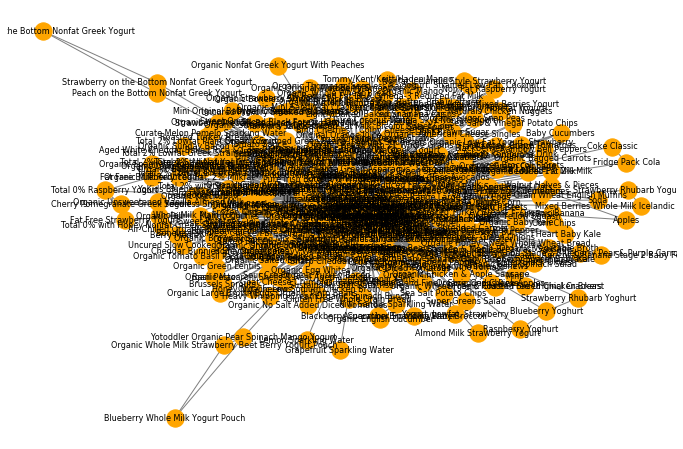

In [461]:
fig, ax = plt.subplots(figsize = (12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, font_size = 8,
                edge_color = 'grey', node_color = 'orange',
                with_labels = True, ax = ax)

# for key, value in pos.items():
#     x, y = value[0]+.135, value[1]+.045
#     ax.text(x, y,
#             s=key,
#             bbox=dict(facecolor='red', alpha=0.25),
#             horizontalalignment='center', fontsize=7)
    
plt.axis('off')

(-1.0596692684095153,
 1.0982751981390446,
 -0.653490808892056,
 0.5271625854758586)

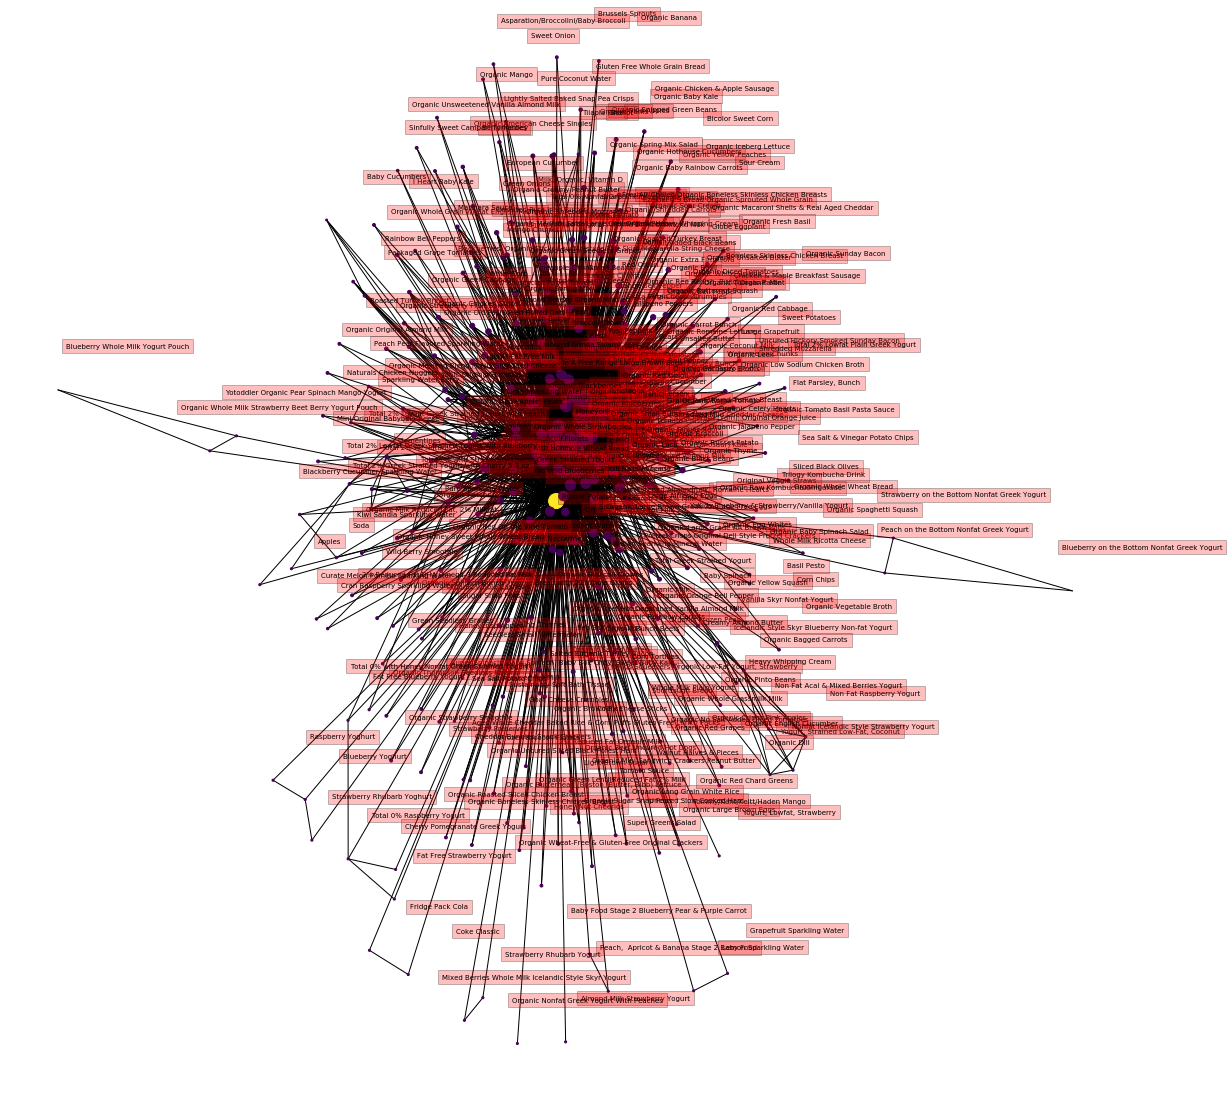

In [462]:
pos2 = nx.spring_layout(G)
eigCent = nx.eigenvector_centrality(G)
node_color = [np.exp(G.degree(v)) for v in G]
node_size =  [v * 1000 for v in eigCent.values()]
f, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(G, pos=pos2, with_labels=False,
                 node_color=node_color,
                 node_size=node_size, font_size = 8, ax = ax )

for key, value in pos2.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=7)

plt.axis('off')

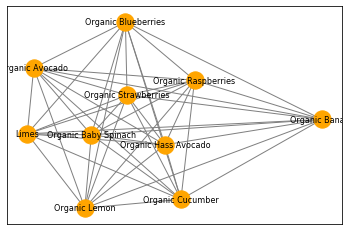

In [11]:
pos = nx.spring_layout(G)
G_sub = nx.ego_graph(G, n = 'Organic Banana', radius=1, center=True, undirected=False, distance=None)
pos3 = nx.spring_layout(G_sub)
nx.draw_networkx(G_sub, pos=pos3, with_labels=True,
                edge_color = 'grey', node_color = 'orange', font_size = 8)

In [12]:
# Traverse the graph by selecting the most weighted item
def traverse_graph(item, traversals, cutoff = 1, random_ = False):
    ''' Function that finds items in the graph 'cutoff' length away
    Args: item: the start node for searching -> str
          traversals: how many results to return -> int
          cutoff - depth of neighbourhood to search -> int
          random_ - indicates whether to jump to a neighbour at random (True) or to choose the one
                    with the greatest weight (False) -> bool
    Returns: a list of connected ingredients
    '''
    items = []
    items.append(item)
    for _ in range(traversals):
        connections = nx.single_source_shortest_path_length(G, source = item, cutoff = cutoff)
        del connections[item]
        neighbours = {}
        for conn in connections:
            neighbours[conn] = G.get_edge_data(item, conn)['weight']

        weighted_neighbours = {k: v for k, v in sorted(neighbours.items(), key = lambda item: item[1], reverse = True)}    
           
        if random_:    
            new_item = random.sample(set(weighted_neighbours.keys()), 1)[0]
        else:
            new_item = list(weighted_neighbours.keys())[0]
        
        i = 1

        while new_item in items:
            if random_:    
                new_item = random.sample(set(weighted_neighbours.keys()), 1)[0]
            else:
                new_item = list(weighted_neighbours.keys())[i]
            i+=1
            
            if i > 20:
                break
            
        item = new_item
        items.append(item)
    
    return items

def find_ingredient(ingredient, nodes):
    ''' Function that returns the closet match to an ingredient in the graph
    Args: ingredient: the ingredient you want to find -> str
          nodes: a list of the nodes in the graph -> list
    Returns: a list of the closest ingredients found
    '''
    ingredients = []
#     if not ingredient in nodes:
    for node in nodes:
        if ingredient in node:
            ingredients.append(node)
#     else:
#         ingredients.append(ingredient)
    return ingredients


In [13]:
find_ingredient('Apple', nodes)

['Organic Fuji Apple',
 'Apple Honeycrisp Organic',
 'Honeycrisp Apple',
 'Organic Large Extra Fancy Fuji Apple',
 'Organic Gala Apples',
 'Organic Granny Smith Apple',
 'Gala Apples',
 'Granny Smith Apples',
 'Organic AppleApple',
 'Organic Chicken & Apple Sausage',
 'Organic Red Delicious Apple',
 'Organic Cripps Pink Apples',
 'Honeycrisp Apples',
 'Organic Golden Delicious Apple',
 'Organic Apple Juice',
 'Organic Braeburn Apple',
 'Broccoli & Apple Stage 2 Baby Food',
 'Organic Raw Unfiltered Apple Cider Vinegar',
 'Apple Cinnamon GoGo Squeez',
 'Apples',
 'Apple and Carrot Stage 2 Baby Food',
 'Organic Apple Slices',
 'Apple Pie Fruit & Nut Food Bar',
 'Stage 1 Apples Sweet Potatoes Pumpkin & Blueberries Organic Pureed Baby Food',
 'Organic Go Go Apple Peach Applesauce',
 'Pink Lady Apple Kombucha']

In [14]:
# list(weighted_neighbours.keys())
shopping_list = traverse_graph(item = 'Boneless Skinless Chicken Breast', traversals = 20, random_ = True)
shopping_list

['Boneless Skinless Chicken Breast',
 'Organic Garlic',
 'Sparkling Water Grapefruit',
 'Strawberries',
 '2% Reduced Fat Organic Milk',
 'Organic Baby Spinach',
 'Organic Red Chard Greens',
 'Organic Lacinato (Dinosaur) Kale',
 'Organic Blueberries',
 'Organic Spring Mix',
 'Organic Whole Milk',
 'Sea Salt Pita Chips',
 'Organic Avocado',
 'Organic Bread with 21 Whole Grains',
 'Banana',
 'Raspberries',
 'Organic Half & Half',
 'Organic 2% Reduced Fat Milk',
 'Organic Fuji Apple',
 'No Salt Added Black Beans',
 'Boneless Skinless Chicken Breasts']

# Using Plotly to make the graph interactive
The code below makes an interactive map using plotly

In [23]:
# Get the nodes for plotting the graph below
nodes = [node for node in G.nodes()]

In [24]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    hovertext= "12",
    text = nodes,
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'{str(len(adjacencies[1]))} connections')

node_trace.marker.color = node_adjacencies
node_trace.hovertext = node_text

In [25]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Graph of shopping cart items',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="some text",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()